# CNN with MNIST dataset using Pytorch Lightning



In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import pytorch_lightning as pl
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

ModuleNotFoundError: No module named 'pytorch_lightning'

## Load and look at MNIST data

MNIST data are available from keras directly.

Note the shape of the data array: (number_of_samples, dimension_1, dimension_2)

In [2]:
# Data preparation
# Define transformations for the dataset (normalize to [0, 1])
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))# Normalize with mean=0.5 and std=0.5
])

train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
val_dataset   = [train_dataset[i] for i in range(10000,11000)]            # subset of data to save training time
train_dataset = [train_dataset[i] for i in range(11000)]

test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)
test_dataset = [test_dataset[i] for i in range(1000)]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset)

### A look at the data

In [5]:
train_dataset.shape

AttributeError: 'list' object has no attribute 'shape'

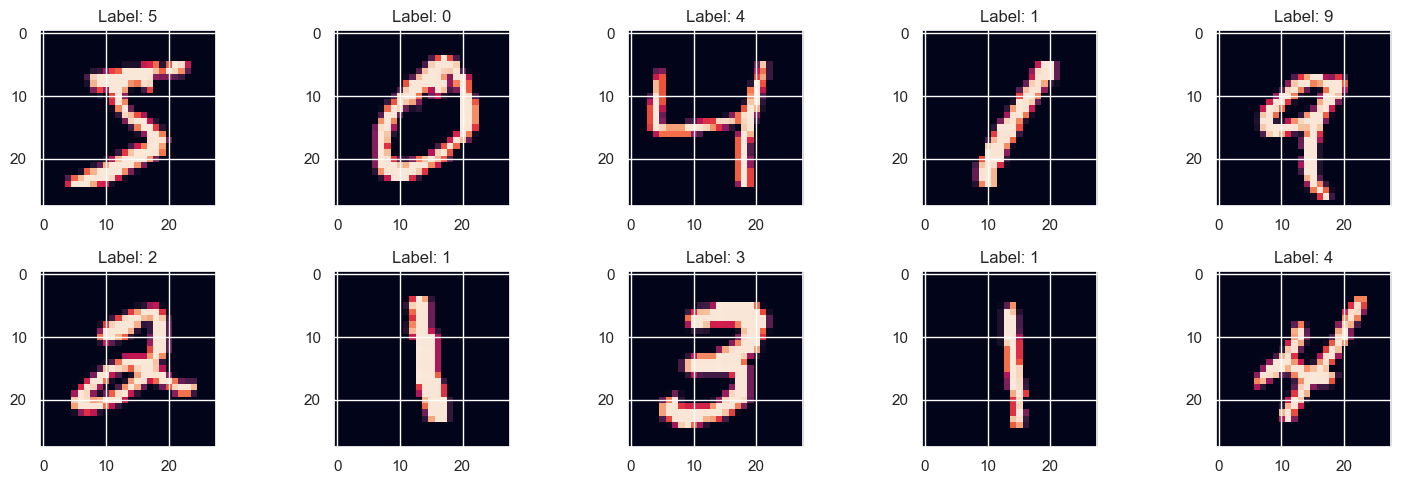

In [7]:
rows = 2
cols = 5
axes=[]
fig=plt.figure(figsize=(15,5))

for i in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    subplot_title=("Label: "+str(train_dataset[i][1]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(train_dataset[i][0].squeeze(0))
fig.tight_layout()    
plt.show()


## Prepare data subsets

The data are already separated in train and test sets at the loading step. This is specific to pre-processed datasets. Things to do:

* the labels are not in the categorical format. This must be done here.
* The input data are not in the appropriate shape. The images are in black and white, with only one array, and without any dimension for the channels. The channel dimension must be introduced for Keras.
* The input data are not normalized. This must be done.

## Design a CNN

In [8]:


# Define the CNN using LightningModule
class SimpleCNN(pl.LightningModule):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.lin1 = nn.Linear(5*5*16, 64)
        self.lin2 = nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = self.criterion(output, target)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = self.criterion(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / len(target)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', accuracy, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

## Training

In [9]:
# Instantiate the model
model = SimpleCNN()

# Define the trainer
trainer = pl.Trainer(max_epochs=5, log_every_n_steps=50, accelerator='auto')

# Train the model
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | flatten   | Flatten          | 0     
1 | relu      | ReLU             | 0     
2 | dropout   | Dropout          | 0     
3 | maxpool2d | MaxPool2d        | 0     
4 | conv1     | Conv2d           | 320   
5 | conv2     | Conv2d           | 4.6 K 
6 | lin1      | Linear           | 25.7 K
7 | lin2      | Linear           | 650   
8 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
31.3 K    Trainable params
0         Non-trainable params
31.3 K    Total params
0.125     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/cosmee/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cosmee/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## Make prediction with test dataset

The output is in the categorical format. For visualisation, it is changed to label format.

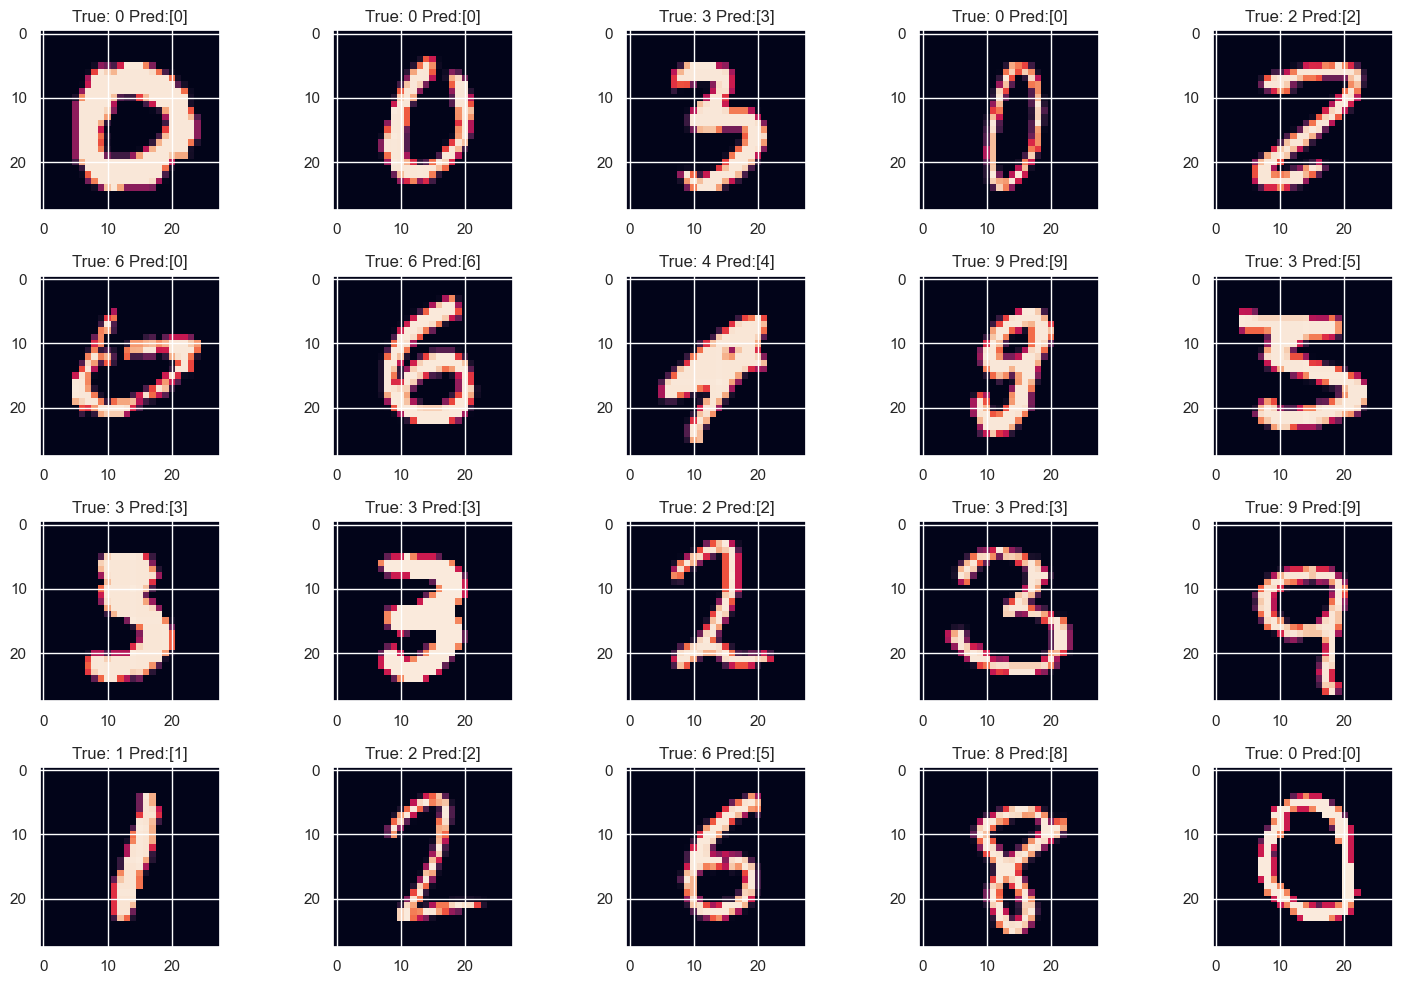

In [10]:
rows = 4
cols = 5
start = 440
axes=[]
fig=plt.figure(figsize=(15,10))

for i in range(rows*cols):
    j = start+i
    
    test_data = test_dataset[j][0]
    z = model(test_data.unsqueeze(1))
    pred_label = np.argmax(z.detach().numpy(), axis=1)
    test_image = test_data.squeeze(0)
    test_label = test_dataset[j][1]

    axes.append( fig.add_subplot(rows, cols, i+1) )
    subplot_title=("True: "+str(test_label)+" Pred:"+str(pred_label))
    axes[-1].set_title(subplot_title)  
    plt.imshow(test_image)
fig.tight_layout()    
plt.show()
